In [70]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit import Aer
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from numpy.random import randint

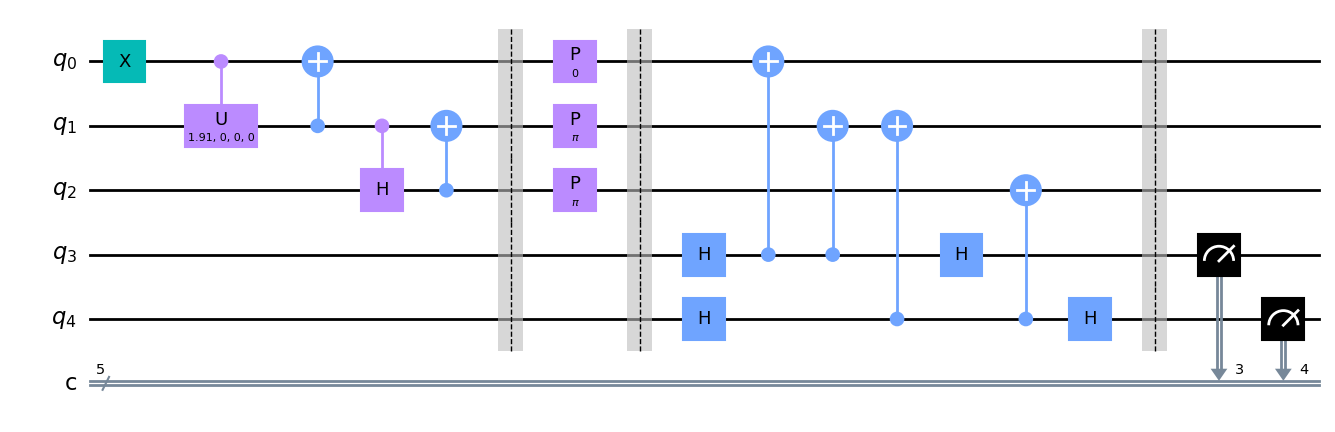

01000


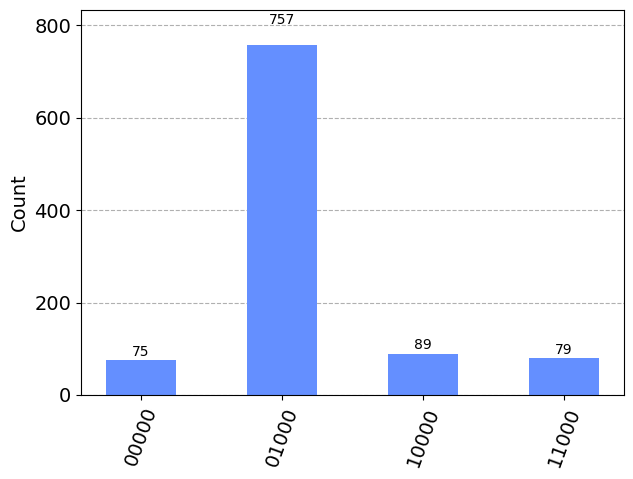

In [11]:
qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.x(qreg_q[0])
circuit.cu(1.91, 0, 0, 0, qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[0])
circuit.ch(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[1])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
circuit.p(0, qreg_q[0])
circuit.p(pi, qreg_q[1])
circuit.p(pi, qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
circuit.h(qreg_q[3])
circuit.h(qreg_q[4])
circuit.cx(qreg_q[3], qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[1])
circuit.cx(qreg_q[4], qreg_q[1])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.h(qreg_q[3])
circuit.h(qreg_q[4])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
circuit.measure(qreg_q[3], creg_c[3])
circuit.measure(qreg_q[4], creg_c[4])
display(circuit.draw())
 # Get the classical bit values from the result
result = execute(circuit, Aer.get_backend('qasm_simulator'), shots=1000).result()
counts = result.get_counts(circuit)
print(counts.most_frequent())
plot_histogram(result.get_counts())
# @columns [0,1,2,3,4,5,6,6,6,7,8,8,9,10,11,12,13,13,14,15,16]

In [37]:
#Alice encodes using phase encoding
def phase_encoding(bit1, bit2, circuit, qreg_q):
    encoding = []
    if bit1==0 and bit2==1: #message is 10, i.e,qiskit reads 01
        circuit.p(0, qreg_q[0])
        circuit.p(pi, qreg_q[1])
        circuit.p(pi, qreg_q[2])
        encoding.append('pi 0')
    elif bit1==1 and bit2==1:  #message is 11, i.e, phase difference is pi and pi
        circuit.p(pi, qreg_q[0])
        circuit.p(0, qreg_q[1])
        circuit.p(pi, qreg_q[2])
        encoding.append('pi pi')
    elif bit1==1 and bit2==0:  #message is 01, i.e, phase difference is 0 and 1
        circuit.p(0, qreg_q[0])
        circuit.p(0, qreg_q[1])
        circuit.p(pi, qreg_q[2])
        encoding.append('0 pi')
    elif bit1==0 and bit2==0:
        circuit.p(0, qreg_q[0])
        circuit.p(0, qreg_q[1])
        circuit.p(0, qreg_q[2])
        encoding.append('0 0')
    else:
        raise ValueError("Invalid input bits. Please provide valid values (0 or 1) for bit1 and bit2.")
    return circuit, encoding

In [86]:
def dps_qkd(alice_key, bob_key):
    encoding_array = []
    circuits = []
    # Check if 'alice_key' is a NumPy array, and convert if necessary
    if not isinstance(alice_key, np.ndarray):
        alice_key = np.array(alice_key)
                             
    #This is a 3 qubit circuit, so we can send 2 bits of phase information at a time. Thus, we break down a message into pairs of two qubits at a time.
    if len(alice_key) % 2 != 0:
        # Add 0 at the end to make the length even
        alice_key.append(0)
    # Use list comprehension to create pairs
    groups_of_2 = [(alice_key[i], alice_key[i + 1]) for i in range(0, len(alice_key), 2)]
    
      # alice and bob exchange 2 bits
    for group in groups_of_2:
        reg_q = QuantumRegister(5, 'q')
        creg_c = ClassicalRegister(5, 'c')
        circuit = QuantumCircuit(qreg_q, creg_c)
        circuit.x(qreg_q[0])
        circuit.cu(1.91, 0, 0, 0, qreg_q[0], qreg_q[1])
        circuit.cx(qreg_q[1], qreg_q[0])
        circuit.ch(qreg_q[1], qreg_q[2])
        circuit.cx(qreg_q[2], qreg_q[1])
        circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
        
        circuit, encoding = phase_encoding(*group, circuit, qreg_q)
        encoding_array.append(encoding)
        
        circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.h(qreg_q[3])
        circuit.h(qreg_q[4])
        circuit.cx(qreg_q[3], qreg_q[0])
        circuit.cx(qreg_q[3], qreg_q[1])
        circuit.cx(qreg_q[4], qreg_q[1])
        circuit.cx(qreg_q[4], qreg_q[2])
        circuit.h(qreg_q[3])
        circuit.h(qreg_q[4])
        circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.measure(qreg_q[3], creg_c[3])
        circuit.measure(qreg_q[4], creg_c[4])
        circuits.append(circuit)
        #display(circuit.draw())
    # takes circuits out of loop, send them all at once for excution
    
    # Simulate all circuits using the statevector simulator
    backend = Aer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    #convert results array into list; iterate over results to get counts for each result
    
    #print("Total number of results : ",len(results.get_counts()))
    #print(results.get_counts())
    result=list(results.get_counts())
    #sd_list = list(result.values())
    #print(result)

    for r in list(results.get_counts()):
        #print(r)
        print(r.most_frequent()[0:2])
        bob_key.append(int(r.most_frequent()[0:1]))
        bob_key.append(int(r.most_frequent()[1:2]))
        
    # Get the counts from the results of all circuits
    #count = results.get_counts(circuits)
    #print(counts)
    #print(counts.most_frequent())

    # Extract the classical bit value from the counts
    # bit1_value = int(list(counts.keys())[3], 2)
    # bit2_value = int(list(counts.keys())[4], 2)
    # bob_key.append(bit1_value)
    # bob_key.append(bit2_value)
    #return encoding_array, counts

In [89]:
# Example usage
alice_key = [0, 1, 1, 0, 1, 1]
bob_key = []
dps_qkd(alice_key, bob_key)
print(f"Key sent by Alice: {alice_key}")
print(f"Key received by Bob: {bob_key}")
# print(f"Phase encoding used by Alice: {encoding_array}")

01
10
11
Key sent by Alice: [0, 1, 1, 0, 1, 1]
Key received by Bob: [0, 1, 1, 0, 1, 1]


In [90]:
# call the function
n=50
bob_key = []
np.random.seed(seed=0)
alice_key = randint(2, size=n)
dps_qkd(alice_key, bob_key)
print(f"Key sent by Alice: {alice_key}")
print(f"Key received by Bob: {bob_key}")
print(len(alice_key))
print(len(bob_key))
# print(f"Phase encoding used by Alice: {encoding_array}")

01
10
11
11
11
10
01
00
00
01
01
10
01
11
10
10
10
11
01
10
01
01
11
11
01
Key sent by Alice: [0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1]
Key received by Bob: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
50
50
